In [1]:
trial_number_ml = "003"
random_state_init = 333

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 15:15:30,093] A new study created in memory with name: no-name-82ce384e-c45a-4e34-846b-01dbb7324180


[I 2024-05-01 15:16:15,080] Trial 1 finished with value: 0.7166072390008026 and parameters: {'n_estimators': 401, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7166072390008026.


[I 2024-05-01 15:16:15,184] Trial 0 finished with value: 0.7315885980150144 and parameters: {'n_estimators': 417, 'max_depth': 52, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.7315885980150144.


[I 2024-05-01 15:16:42,627] Trial 3 finished with value: 0.7271284755025955 and parameters: {'n_estimators': 722, 'max_depth': 78, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7315885980150144.


[I 2024-05-01 15:16:50,622] Trial 2 finished with value: 0.7233027560214955 and parameters: {'n_estimators': 805, 'max_depth': 77, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7315885980150144.


[I 2024-05-01 15:16:51,456] Trial 5 finished with value: 0.714697426832861 and parameters: {'n_estimators': 361, 'max_depth': 86, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.7315885980150144.


[I 2024-05-01 15:16:55,634] Trial 6 pruned. 


[I 2024-05-01 15:17:14,837] Trial 8 finished with value: 0.7319111327827386 and parameters: {'n_estimators': 145, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.7319111327827386.


[I 2024-05-01 15:17:33,496] Trial 10 pruned. 


[I 2024-05-01 15:17:53,766] Trial 4 finished with value: 0.7268110200225519 and parameters: {'n_estimators': 926, 'max_depth': 86, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 8 with value: 0.7319111327827386.


[I 2024-05-01 15:18:49,000] Trial 7 finished with value: 0.7331840022755209 and parameters: {'n_estimators': 977, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 7 with value: 0.7331840022755209.


[I 2024-05-01 15:19:19,660] Trial 11 finished with value: 0.7303182681660724 and parameters: {'n_estimators': 649, 'max_depth': 94, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.7331840022755209.


[I 2024-05-01 15:19:26,620] Trial 14 pruned. 


[I 2024-05-01 15:19:34,873] Trial 9 finished with value: 0.7300008126860289 and parameters: {'n_estimators': 963, 'max_depth': 56, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.7331840022755209.


[I 2024-05-01 15:19:46,952] Trial 12 finished with value: 0.7338214528794482 and parameters: {'n_estimators': 688, 'max_depth': 84, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 12 with value: 0.7338214528794482.


[I 2024-05-01 15:19:54,645] Trial 15 finished with value: 0.7319111327827386 and parameters: {'n_estimators': 109, 'max_depth': 40, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.7338214528794482.


[I 2024-05-01 15:20:28,531] Trial 16 finished with value: 0.7363748107965339 and parameters: {'n_estimators': 210, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.7363748107965339.


[I 2024-05-01 15:21:13,217] Trial 13 finished with value: 0.7360512601712735 and parameters: {'n_estimators': 570, 'max_depth': 38, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.7363748107965339.


[I 2024-05-01 15:21:33,673] Trial 18 finished with value: 0.732864007151637 and parameters: {'n_estimators': 531, 'max_depth': 67, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 16 with value: 0.7363748107965339.


[I 2024-05-01 15:21:45,319] Trial 21 pruned. 


[I 2024-05-01 15:22:21,440] Trial 17 finished with value: 0.7338189132356078 and parameters: {'n_estimators': 822, 'max_depth': 62, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 16 with value: 0.7363748107965339.


[I 2024-05-01 15:22:43,837] Trial 19 finished with value: 0.7363748107965339 and parameters: {'n_estimators': 507, 'max_depth': 66, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.7363748107965339.


[I 2024-05-01 15:23:35,225] Trial 20 finished with value: 0.7373297168805046 and parameters: {'n_estimators': 526, 'max_depth': 62, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.7373297168805046.


[I 2024-05-01 15:24:00,522] Trial 22 finished with value: 0.7389225814971708 and parameters: {'n_estimators': 525, 'max_depth': 36, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:24:43,900] Trial 23 finished with value: 0.7389220735684028 and parameters: {'n_estimators': 525, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:24:59,209] Trial 24 finished with value: 0.7366917583478093 and parameters: {'n_estimators': 509, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:25:09,735] Trial 26 finished with value: 0.7347794065360274 and parameters: {'n_estimators': 256, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:25:28,615] Trial 27 pruned. 


[I 2024-05-01 15:25:39,236] Trial 29 pruned. 


[I 2024-05-01 15:25:51,472] Trial 25 finished with value: 0.7360558315301862 and parameters: {'n_estimators': 503, 'max_depth': 68, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:26:59,226] Trial 31 finished with value: 0.7354163492111867 and parameters: {'n_estimators': 338, 'max_depth': 46, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:27:15,090] Trial 32 finished with value: 0.7357353284775343 and parameters: {'n_estimators': 350, 'max_depth': 58, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:27:21,336] Trial 33 pruned. 


[I 2024-05-01 15:27:34,890] Trial 28 finished with value: 0.7366907424902733 and parameters: {'n_estimators': 597, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7389225814971708.


[I 2024-05-01 15:27:40,098] Trial 34 pruned. 


[I 2024-05-01 15:27:45,347] Trial 30 finished with value: 0.7402000223488658 and parameters: {'n_estimators': 584, 'max_depth': 57, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.7402000223488658.


[I 2024-05-01 15:28:26,713] Trial 38 pruned. 


[I 2024-05-01 15:29:12,899] Trial 36 finished with value: 0.7366932821341134 and parameters: {'n_estimators': 422, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.7402000223488658.


[I 2024-05-01 15:29:13,700] Trial 37 pruned. 


[I 2024-05-01 15:29:33,005] Trial 40 pruned. 


[I 2024-05-01 15:29:34,573] Trial 41 pruned. 


[I 2024-05-01 15:29:36,448] Trial 35 finished with value: 0.7335055211857089 and parameters: {'n_estimators': 604, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.7402000223488658.


[I 2024-05-01 15:29:44,126] Trial 42 pruned. 


[I 2024-05-01 15:29:45,755] Trial 43 pruned. 


[I 2024-05-01 15:30:12,908] Trial 39 finished with value: 0.738604110159591 and parameters: {'n_estimators': 623, 'max_depth': 76, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.7402000223488658.


[I 2024-05-01 15:30:29,297] Trial 47 pruned. 


[I 2024-05-01 15:30:40,707] Trial 44 finished with value: 0.7414708601265758 and parameters: {'n_estimators': 375, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.7414708601265758.


[I 2024-05-01 15:30:50,923] Trial 48 pruned. 


[I 2024-05-01 15:30:51,154] Trial 45 finished with value: 0.7373271772366643 and parameters: {'n_estimators': 402, 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.7414708601265758.


[I 2024-05-01 15:30:56,050] Trial 49 pruned. 


[I 2024-05-01 15:30:58,214] Trial 46 finished with value: 0.7401984985625616 and parameters: {'n_estimators': 552, 'max_depth': 51, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 44 with value: 0.7414708601265758.


Best trial for RandomForestClassifier:
  Value: 0.7414708601265758
  Params: 
    n_estimators: 375
    max_depth: 45
    min_samples_split: 7
    min_samples_leaf: 2
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 375, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2024-05-01 15:31:08,426] A new study created in memory with name: no-name-75d2e74c-855f-4cc2-a646-8f875620b017


RandomForestClassifier accuracy: 0.7325



[I 2024-05-01 15:31:12,916] Trial 0 finished with value: 0.7217154786212782 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1686846365448247, 'min_child_weight': 8, 'subsample': 0.6918084299917389, 'colsample_bytree': 0.6250878012176367, 'gamma': 4.9589370864346085, 'reg_lambda': 2.627948761106187, 'reg_alpha': 0.15464520625802977}. Best is trial 0 with value: 0.7217154786212782.


[I 2024-05-01 15:31:17,701] Trial 3 finished with value: 0.7044946616686476 and parameters: {'n_estimators': 388, 'max_depth': 8, 'learning_rate': 0.27449364777565294, 'min_child_weight': 4, 'subsample': 0.7149522222458669, 'colsample_bytree': 0.6363023227180996, 'gamma': 2.577333206631292, 'reg_lambda': 0.11405276080489266, 'reg_alpha': 0.04069562247320744}. Best is trial 0 with value: 0.7217154786212782.


[I 2024-05-01 15:31:18,971] Trial 1 finished with value: 0.7201149950730908 and parameters: {'n_estimators': 589, 'max_depth': 10, 'learning_rate': 0.19103075532641636, 'min_child_weight': 3, 'subsample': 0.9736378726827716, 'colsample_bytree': 0.831294689135023, 'gamma': 4.389952814984468, 'reg_lambda': 0.35203808033264733, 'reg_alpha': 1.4689248061233464}. Best is trial 0 with value: 0.7217154786212782.


[I 2024-05-01 15:31:21,382] Trial 4 finished with value: 0.7287254035494063 and parameters: {'n_estimators': 215, 'max_depth': 6, 'learning_rate': 0.026778782845054867, 'min_child_weight': 7, 'subsample': 0.7294799651915231, 'colsample_bytree': 0.7956632810053053, 'gamma': 2.399379789828415, 'reg_lambda': 5.140185216586795, 'reg_alpha': 0.2821667774100167}. Best is trial 4 with value: 0.7287254035494063.


[I 2024-05-01 15:31:22,466] Trial 2 finished with value: 0.7194780523979316 and parameters: {'n_estimators': 910, 'max_depth': 5, 'learning_rate': 0.2918505935721502, 'min_child_weight': 1, 'subsample': 0.505285977214414, 'colsample_bytree': 0.9052815827971104, 'gamma': 2.4698193822104058, 'reg_lambda': 0.034697917297014845, 'reg_alpha': 5.100548097649453}. Best is trial 4 with value: 0.7287254035494063.


[I 2024-05-01 15:31:22,524] Trial 5 finished with value: 0.7252115523319009 and parameters: {'n_estimators': 209, 'max_depth': 9, 'learning_rate': 0.279575224296143, 'min_child_weight': 4, 'subsample': 0.7255675244042428, 'colsample_bytree': 0.5509752799657204, 'gamma': 1.5618370362620375, 'reg_lambda': 0.01352151201140799, 'reg_alpha': 6.289354360061735}. Best is trial 4 with value: 0.7287254035494063.


[I 2024-05-01 15:31:23,973] Trial 6 finished with value: 0.7382866546795477 and parameters: {'n_estimators': 111, 'max_depth': 7, 'learning_rate': 0.07004485780526762, 'min_child_weight': 6, 'subsample': 0.5581031252772919, 'colsample_bytree': 0.9654977471594217, 'gamma': 2.347122340125045, 'reg_lambda': 2.3746230158953603, 'reg_alpha': 0.20241954745480678}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:25,501] Trial 7 finished with value: 0.7287254035494062 and parameters: {'n_estimators': 155, 'max_depth': 6, 'learning_rate': 0.1319951217370803, 'min_child_weight': 6, 'subsample': 0.7251926413037038, 'colsample_bytree': 0.9180605047001631, 'gamma': 3.8384957431946236, 'reg_lambda': 5.848780567606176, 'reg_alpha': 2.3721662180418046}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:26,385] Trial 10 pruned. 


[I 2024-05-01 15:31:27,668] Trial 11 pruned. 


[I 2024-05-01 15:31:27,761] Trial 8 pruned. 


[I 2024-05-01 15:31:28,477] Trial 13 pruned. 


[I 2024-05-01 15:31:28,550] Trial 14 pruned. 


[I 2024-05-01 15:31:28,814] Trial 12 pruned. 


[I 2024-05-01 15:31:32,550] Trial 9 finished with value: 0.7271269517162914 and parameters: {'n_estimators': 338, 'max_depth': 9, 'learning_rate': 0.06352503129844629, 'min_child_weight': 3, 'subsample': 0.7189303956065836, 'colsample_bytree': 0.8153663228130505, 'gamma': 2.669440557764809, 'reg_lambda': 0.05259803198079873, 'reg_alpha': 0.6007613500150858}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:34,268] Trial 18 pruned. 


[I 2024-05-01 15:31:35,016] Trial 15 finished with value: 0.7277638943914505 and parameters: {'n_estimators': 219, 'max_depth': 4, 'learning_rate': 0.08072953107411693, 'min_child_weight': 8, 'subsample': 0.6098672341232322, 'colsample_bytree': 0.7963176071158853, 'gamma': 1.910805472729871, 'reg_lambda': 1.3046489443416798, 'reg_alpha': 0.3798896285476266}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:35,564] Trial 17 finished with value: 0.7309552108412316 and parameters: {'n_estimators': 194, 'max_depth': 5, 'learning_rate': 0.023554403452413615, 'min_child_weight': 8, 'subsample': 0.6144626694453054, 'colsample_bytree': 0.8340874220974539, 'gamma': 0.8090244503198718, 'reg_lambda': 1.761054028825163, 'reg_alpha': 0.5720455302107507}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:36,563] Trial 21 pruned. 


[I 2024-05-01 15:31:36,879] Trial 16 finished with value: 0.729680309633377 and parameters: {'n_estimators': 231, 'max_depth': 5, 'learning_rate': 0.020892382179691686, 'min_child_weight': 8, 'subsample': 0.6183590970197149, 'colsample_bytree': 0.7870005844704605, 'gamma': 0.9165683255436679, 'reg_lambda': 2.0417096610429257, 'reg_alpha': 0.5127394426607189}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:37,562] Trial 23 pruned. 


[I 2024-05-01 15:31:37,776] Trial 22 pruned. 


[I 2024-05-01 15:31:43,150] Trial 19 finished with value: 0.7255305315982487 and parameters: {'n_estimators': 239, 'max_depth': 4, 'learning_rate': 0.10806113203607937, 'min_child_weight': 8, 'subsample': 0.622083546731456, 'colsample_bytree': 0.7719882093811893, 'gamma': 2.0592197172368327, 'reg_lambda': 9.338943436800298, 'reg_alpha': 0.1517068319518874}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:44,285] Trial 20 finished with value: 0.7287218480480298 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.11321535521740392, 'min_child_weight': 7, 'subsample': 0.8178140788260067, 'colsample_bytree': 0.9026604034590642, 'gamma': 0.3359188097324206, 'reg_lambda': 9.73403188229707, 'reg_alpha': 0.11631932404711354}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:46,300] Trial 27 pruned. 


[I 2024-05-01 15:31:47,989] Trial 24 finished with value: 0.7319080852101301 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.041498472455780075, 'min_child_weight': 7, 'subsample': 0.5722413650720732, 'colsample_bytree': 0.7144594938200386, 'gamma': 1.151500468790434, 'reg_lambda': 2.938805304206316, 'reg_alpha': 0.868141617950939}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:48,030] Trial 25 finished with value: 0.736689726632737 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.036292767061893993, 'min_child_weight': 7, 'subsample': 0.6489193229763491, 'colsample_bytree': 0.7445884927121778, 'gamma': 1.444940187711119, 'reg_lambda': 2.374325346610623, 'reg_alpha': 0.7086001214096443}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:52,870] Trial 30 pruned. 


[I 2024-05-01 15:31:56,328] Trial 28 pruned. 


[I 2024-05-01 15:31:58,293] Trial 26 finished with value: 0.7376466644317801 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.035814363898049144, 'min_child_weight': 7, 'subsample': 0.7928139663261997, 'colsample_bytree': 0.7064767208156297, 'gamma': 1.455281334642079, 'reg_lambda': 2.4842300313248886, 'reg_alpha': 0.643396875810702}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:31:59,118] Trial 29 pruned. 


[I 2024-05-01 15:32:00,757] Trial 31 pruned. 


[I 2024-05-01 15:32:03,573] Trial 33 pruned. 


[I 2024-05-01 15:32:04,805] Trial 34 pruned. 


[I 2024-05-01 15:32:07,231] Trial 37 pruned. 


[I 2024-05-01 15:32:08,589] Trial 36 pruned. 


[I 2024-05-01 15:32:11,972] Trial 38 pruned. 


[I 2024-05-01 15:32:17,565] Trial 32 finished with value: 0.7248920651367852 and parameters: {'n_estimators': 476, 'max_depth': 6, 'learning_rate': 0.1578804020291466, 'min_child_weight': 7, 'subsample': 0.6738200863544918, 'colsample_bytree': 0.5416003866161819, 'gamma': 3.07657062890808, 'reg_lambda': 3.664331357878834, 'reg_alpha': 0.9982648734613769}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:32:17,575] Trial 40 pruned. 


[I 2024-05-01 15:32:19,277] Trial 35 pruned. 


[I 2024-05-01 15:32:22,737] Trial 42 pruned. 


[I 2024-05-01 15:32:23,516] Trial 43 pruned. 


[I 2024-05-01 15:32:24,014] Trial 41 pruned. 


[I 2024-05-01 15:32:25,638] Trial 44 pruned. 


[I 2024-05-01 15:32:26,930] Trial 46 pruned. 


[I 2024-05-01 15:32:29,492] Trial 47 pruned. 


[I 2024-05-01 15:32:34,182] Trial 49 pruned. 


[I 2024-05-01 15:32:36,237] Trial 45 finished with value: 0.7331860339905931 and parameters: {'n_estimators': 185, 'max_depth': 5, 'learning_rate': 0.024435685547489414, 'min_child_weight': 8, 'subsample': 0.5977027310159871, 'colsample_bytree': 0.7163022478224279, 'gamma': 0.9281045365017078, 'reg_lambda': 1.6135027837796307, 'reg_alpha': 0.5601670719646892}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:32:37,488] Trial 39 finished with value: 0.7274433913387987 and parameters: {'n_estimators': 702, 'max_depth': 3, 'learning_rate': 0.06334691453493181, 'min_child_weight': 7, 'subsample': 0.6917203945479006, 'colsample_bytree': 0.72138437783974, 'gamma': 2.28615148413221, 'reg_lambda': 0.5144071800235701, 'reg_alpha': 2.391972280894327}. Best is trial 6 with value: 0.7382866546795477.


[I 2024-05-01 15:32:40,242] Trial 48 finished with value: 0.7347773748209552 and parameters: {'n_estimators': 383, 'max_depth': 6, 'learning_rate': 0.06943634378658235, 'min_child_weight': 8, 'subsample': 0.8512097231194504, 'colsample_bytree': 0.7135355415443176, 'gamma': 1.1765369933863024, 'reg_lambda': 0.9451597561498001, 'reg_alpha': 2.482146555547733}. Best is trial 6 with value: 0.7382866546795477.


Best trial for XGBClassifier:
  Value: 0.7382866546795477
  Params: 
    n_estimators: 111
    max_depth: 7
    learning_rate: 0.07004485780526762
    min_child_weight: 6
    subsample: 0.5581031252772919
    colsample_bytree: 0.9654977471594217
    gamma: 2.347122340125045
    reg_lambda: 2.3746230158953603
    reg_alpha: 0.20241954745480678

Best hyperparameters for XGBClassifier: {'n_estimators': 111, 'max_depth': 7, 'learning_rate': 0.07004485780526762, 'min_child_weight': 6, 'subsample': 0.5581031252772919, 'colsample_bytree': 0.9654977471594217, 'gamma': 2.347122340125045, 'reg_lambda': 2.3746230158953603, 'reg_alpha': 0.20241954745480678}


[I 2024-05-01 15:33:18,239] A new study created in memory with name: no-name-53ba7c91-6887-4ecf-921c-d033255cfa70


XGBClassifier accuracy: 0.7197



[I 2024-05-01 15:33:18,894] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 2, 'learning_rate': 0.42278734909420695, 'n_estimators': 162, 'min_child_weight': 0.01587683088020009, 'min_child_samples': 1715, 'subsample': 0.9104582407727202, 'colsample_bytree': 0.9378546709270895, 'reg_alpha': 9.510906322440802e-08, 'reg_lambda': 4.192961200435808e-10}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 15:33:19,065] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 14, 'learning_rate': 0.18549943707226982, 'n_estimators': 528, 'min_child_weight': 0.01898542039918185, 'min_child_samples': 1558, 'subsample': 0.9264004274419385, 'colsample_bytree': 0.9805199654901314, 'reg_alpha': 0.0005145520991049841, 'reg_lambda': 3.941307537412124e-07}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 15:33:19,280] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'max_depth': 5, 'learning_rate': 0.3493558296519952, 'n_estimators': 749, 'min_child_weight': 0.0015281473387982777, 'min_child_samples': 1986, 'subsample': 0.9820089115038675, 'colsample_bytree': 0.8786006462013943, 'reg_alpha': 9.552134000374007e-06, 'reg_lambda': 2.0910550295791063e-10}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 15:33:20,137] Trial 2 finished with value: 0.6764392161643251 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 1, 'learning_rate': 0.025370438291379423, 'n_estimators': 344, 'min_child_weight': 0.03073580717458865, 'min_child_samples': 200, 'subsample': 0.8543068355730246, 'colsample_bytree': 0.9314382670397205, 'reg_alpha': 0.26485949685016347, 'reg_lambda': 4.3763927173215375e-05}. Best is trial 2 with value: 0.6764392161643251.


[I 2024-05-01 15:33:22,015] Trial 4 finished with value: 0.6149127886305225 and parameters: {'boosting_type': 'goss', 'num_leaves': 59, 'max_depth': 15, 'learning_rate': 0.24791611685757015, 'n_estimators': 910, 'min_child_weight': 0.0035223989551485583, 'min_child_samples': 892, 'subsample': 0.8427585621289408, 'colsample_bytree': 0.9804769382501154, 'reg_alpha': 0.16326510472425235, 'reg_lambda': 3.195047857832939e-08}. Best is trial 2 with value: 0.6764392161643251.


[I 2024-05-01 15:33:23,161] Trial 8 finished with value: 0.5208931419457736 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 2, 'learning_rate': 0.47245803362709954, 'n_estimators': 794, 'min_child_weight': 0.024993636526104993, 'min_child_samples': 1250, 'subsample': 0.8861967971928306, 'colsample_bytree': 0.9045970079384636, 'reg_alpha': 0.0004644612568528437, 'reg_lambda': 0.00023930337013502903}. Best is trial 2 with value: 0.6764392161643251.


[I 2024-05-01 15:33:23,671] Trial 9 pruned. 


[I 2024-05-01 15:33:25,558] Trial 10 finished with value: 0.6101362264955963 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 12, 'learning_rate': 0.055095534794067834, 'n_estimators': 556, 'min_child_weight': 0.07198224835891666, 'min_child_samples': 1052, 'subsample': 0.8221388278562816, 'colsample_bytree': 0.8581005883775024, 'reg_alpha': 0.0016519091969132722, 'reg_lambda': 5.6413562633298577e-05}. Best is trial 2 with value: 0.6764392161643251.


[I 2024-05-01 15:33:25,677] Trial 6 finished with value: 0.6630461504078669 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 9, 'learning_rate': 0.3843385416282429, 'n_estimators': 375, 'min_child_weight': 0.03709403623117483, 'min_child_samples': 717, 'subsample': 0.8783510743146077, 'colsample_bytree': 0.9388201570645096, 'reg_alpha': 1.241143987479101e-06, 'reg_lambda': 3.626395048801895e-10}. Best is trial 2 with value: 0.6764392161643251.


[I 2024-05-01 15:33:26,432] Trial 7 finished with value: 0.6844025233901199 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 0, 'learning_rate': 0.4000663395821558, 'n_estimators': 910, 'min_child_weight': 0.016782656681075966, 'min_child_samples': 380, 'subsample': 0.8541468688420722, 'colsample_bytree': 0.9808141535050066, 'reg_alpha': 4.615122747264308e-06, 'reg_lambda': 0.4010173065121912}. Best is trial 7 with value: 0.6844025233901199.


[I 2024-05-01 15:33:27,698] Trial 11 finished with value: 0.6853650484056116 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 11, 'learning_rate': 0.4943487625927029, 'n_estimators': 424, 'min_child_weight': 0.004550212357114666, 'min_child_samples': 644, 'subsample': 0.9206647871584404, 'colsample_bytree': 0.877913857165332, 'reg_alpha': 0.11094258125967418, 'reg_lambda': 2.3616995141716644e-07}. Best is trial 11 with value: 0.6853650484056116.


[I 2024-05-01 15:33:37,011] Trial 14 finished with value: 0.6840891313402209 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'max_depth': 8, 'learning_rate': 0.4949301283401264, 'n_estimators': 983, 'min_child_weight': 0.006213728913588342, 'min_child_samples': 391, 'subsample': 0.9678528491689782, 'colsample_bytree': 0.8522890683605854, 'reg_alpha': 3.858951773552097e-09, 'reg_lambda': 0.2701162626594052}. Best is trial 11 with value: 0.6853650484056116.


[I 2024-05-01 15:33:41,167] Trial 5 finished with value: 0.6369106756468472 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 9, 'learning_rate': 0.21153369728699192, 'n_estimators': 727, 'min_child_weight': 0.07865229420516993, 'min_child_samples': 736, 'subsample': 0.9454510831363927, 'colsample_bytree': 0.9122786902831029, 'reg_alpha': 8.698812244848823e-05, 'reg_lambda': 1.2071277030019266e-10}. Best is trial 11 with value: 0.6853650484056116.


[I 2024-05-01 15:33:41,450] Trial 15 finished with value: 0.6984320238929692 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 11, 'learning_rate': 0.3029372273767563, 'n_estimators': 589, 'min_child_weight': 0.0070760270305409295, 'min_child_samples': 531, 'subsample': 0.9530003692130576, 'colsample_bytree': 0.9958575202438341, 'reg_alpha': 2.1710217798510075e-10, 'reg_lambda': 0.7677692239107783}. Best is trial 15 with value: 0.6984320238929692.


[I 2024-05-01 15:33:45,683] Trial 16 finished with value: 0.6898226312741901 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': -1, 'learning_rate': 0.3192806305105314, 'n_estimators': 541, 'min_child_weight': 0.0074123267484008295, 'min_child_samples': 443, 'subsample': 0.8064225519930779, 'colsample_bytree': 0.9989115910029671, 'reg_alpha': 1.4339628961286787e-07, 'reg_lambda': 0.8206237187236016}. Best is trial 15 with value: 0.6984320238929692.


[I 2024-05-01 15:33:48,208] Trial 13 finished with value: 0.7038582269222563 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'max_depth': 8, 'learning_rate': 0.27720433424462576, 'n_estimators': 967, 'min_child_weight': 0.0068391382702497954, 'min_child_samples': 97, 'subsample': 0.97387267204678, 'colsample_bytree': 0.9996154811344669, 'reg_alpha': 1.7832155447813598e-10, 'reg_lambda': 0.4353434215848468}. Best is trial 13 with value: 0.7038582269222563.


[I 2024-05-01 15:33:50,619] Trial 12 pruned. 


[I 2024-05-01 15:34:03,094] Trial 20 finished with value: 0.7102307012464573 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'max_depth': 6, 'learning_rate': 0.12843867563321484, 'n_estimators': 656, 'min_child_weight': 0.0023311207661833554, 'min_child_samples': 122, 'subsample': 0.9930100554165506, 'colsample_bytree': 0.9626284663854324, 'reg_alpha': 1.406964632789616e-10, 'reg_lambda': 0.008694351280460802}. Best is trial 20 with value: 0.7102307012464573.


[I 2024-05-01 15:34:05,888] Trial 17 finished with value: 0.6952498501610134 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 11, 'learning_rate': 0.3008263868419402, 'n_estimators': 536, 'min_child_weight': 0.004823863555224102, 'min_child_samples': 34, 'subsample': 0.9474009468084899, 'colsample_bytree': 0.8327864258423031, 'reg_alpha': 2.8497581499906166e-09, 'reg_lambda': 0.008641241040383841}. Best is trial 20 with value: 0.7102307012464573.


[I 2024-05-01 15:34:09,578] Trial 19 finished with value: 0.6984416745395625 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'max_depth': 11, 'learning_rate': 0.13544275139912482, 'n_estimators': 651, 'min_child_weight': 0.0026298237706228163, 'min_child_samples': 60, 'subsample': 0.9940738025555618, 'colsample_bytree': 0.9598463948776377, 'reg_alpha': 1.7610635750410608e-10, 'reg_lambda': 0.005712897935021785}. Best is trial 20 with value: 0.7102307012464573.


[I 2024-05-01 15:34:11,156] Trial 23 pruned. 


[I 2024-05-01 15:34:13,164] Trial 21 finished with value: 0.7111901786893406 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 6, 'learning_rate': 0.13467329981945672, 'n_estimators': 664, 'min_child_weight': 0.0019493808121103836, 'min_child_samples': 127, 'subsample': 0.990098804519121, 'colsample_bytree': 0.9593840740226193, 'reg_alpha': 2.3980426482945667e-10, 'reg_lambda': 0.0063699870518760275}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:19,616] Trial 25 finished with value: 0.7083178415059072 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'max_depth': 7, 'learning_rate': 0.14325037306090754, 'n_estimators': 655, 'min_child_weight': 0.0021695948014304246, 'min_child_samples': 229, 'subsample': 0.9757256807679153, 'colsample_bytree': 0.9201615654546892, 'reg_alpha': 6.293225320981825e-10, 'reg_lambda': 0.001437701335415564}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:23,771] Trial 26 finished with value: 0.7092702079460376 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 4, 'learning_rate': 0.13666894568525503, 'n_estimators': 662, 'min_child_weight': 0.0020849758655878585, 'min_child_samples': 285, 'subsample': 0.9834070584321813, 'colsample_bytree': 0.9200063911264031, 'reg_alpha': 2.77733292948338e-08, 'reg_lambda': 0.0010881452710343417}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:24,174] Trial 24 finished with value: 0.6990735379270411 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 7, 'learning_rate': 0.14768012959986374, 'n_estimators': 642, 'min_child_weight': 0.0023828360387657603, 'min_child_samples': 46, 'subsample': 0.9987409171615096, 'colsample_bytree': 0.960520402085749, 'reg_alpha': 1.1528647995710305e-10, 'reg_lambda': 0.004340757523518415}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:24,476] Trial 18 finished with value: 0.7095978220014425 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': -1, 'learning_rate': 0.3161783992487928, 'n_estimators': 598, 'min_child_weight': 0.008493182486968991, 'min_child_samples': 36, 'subsample': 0.8018572280166005, 'colsample_bytree': 0.9996820833395028, 'reg_alpha': 1.428717427677704e-10, 'reg_lambda': 0.0034099926524441817}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:27,104] Trial 29 finished with value: 0.6872784160749296 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 3, 'learning_rate': 0.07919290472493107, 'n_estimators': 455, 'min_child_weight': 0.0013095766896569433, 'min_child_samples': 556, 'subsample': 0.8950198513973281, 'colsample_bytree': 0.9716772821591921, 'reg_alpha': 1.0626292563688712e-09, 'reg_lambda': 0.03179339463274974}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:29,545] Trial 28 finished with value: 0.710542569510052 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'max_depth': 3, 'learning_rate': 0.08048196040514378, 'n_estimators': 700, 'min_child_weight': 0.0010258997969958374, 'min_child_samples': 326, 'subsample': 0.9794859714551074, 'colsample_bytree': 0.8946877606029616, 'reg_alpha': 1.1456591184549823e-07, 'reg_lambda': 0.00043353506976485923}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:30,519] Trial 27 finished with value: 0.703527057365475 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'max_depth': 4, 'learning_rate': 0.08258977724004937, 'n_estimators': 667, 'min_child_weight': 0.0012767874830478306, 'min_child_samples': 286, 'subsample': 0.9897555721782056, 'colsample_bytree': 0.8922926025351109, 'reg_alpha': 4.391062196579144e-08, 'reg_lambda': 0.0008660889222927486}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:30,937] Trial 31 pruned. 


[I 2024-05-01 15:34:31,176] Trial 33 pruned. 


[I 2024-05-01 15:34:32,019] Trial 30 finished with value: 0.7073598878493279 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'max_depth': 5, 'learning_rate': 0.21827909550345106, 'n_estimators': 470, 'min_child_weight': 0.011853864789356327, 'min_child_samples': 320, 'subsample': 0.8727897875013247, 'colsample_bytree': 0.9489414951005414, 'reg_alpha': 8.620541388430248e-08, 'reg_lambda': 4.555586710016675e-06}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:35,019] Trial 35 finished with value: 0.6984406586820265 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'max_depth': 1, 'learning_rate': 0.18988870649851589, 'n_estimators': 727, 'min_child_weight': 0.0010512630143827406, 'min_child_samples': 155, 'subsample': 0.9335831170770592, 'colsample_bytree': 0.9862743205626519, 'reg_alpha': 9.653068870404702e-10, 'reg_lambda': 0.0001994504472623102}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:35,532] Trial 32 pruned. 


[I 2024-05-01 15:34:36,036] Trial 36 pruned. 


[I 2024-05-01 15:34:36,562] Trial 37 pruned. 


[I 2024-05-01 15:34:36,928] Trial 34 finished with value: 0.7073639512794725 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 2, 'learning_rate': 0.19586575543266027, 'n_estimators': 724, 'min_child_weight': 0.011758854178824062, 'min_child_samples': 151, 'subsample': 0.942025672408932, 'colsample_bytree': 0.983026978419736, 'reg_alpha': 7.920234951613882e-10, 'reg_lambda': 0.00011357924710206039}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:37,339] Trial 39 pruned. 


[I 2024-05-01 15:34:37,585] Trial 41 pruned. 


[I 2024-05-01 15:34:37,759] Trial 40 pruned. 


[I 2024-05-01 15:34:38,043] Trial 43 pruned. 


[I 2024-05-01 15:34:40,314] Trial 38 finished with value: 0.6955627342821442 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 3, 'learning_rate': 0.24588502184600344, 'n_estimators': 718, 'min_child_weight': 0.009748137109815931, 'min_child_samples': 496, 'subsample': 0.981655998852252, 'colsample_bytree': 0.9306666030184528, 'reg_alpha': 2.3433869428629255e-07, 'reg_lambda': 2.545796377736775e-05}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:44,170] Trial 42 pruned. 


[I 2024-05-01 15:34:45,589] Trial 44 finished with value: 0.7089537683235303 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': 4, 'learning_rate': 0.11686444000313248, 'n_estimators': 679, 'min_child_weight': 0.002584865117225012, 'min_child_samples': 272, 'subsample': 0.9843457659231869, 'colsample_bytree': 0.9109517552295763, 'reg_alpha': 1.254985798135822e-08, 'reg_lambda': 0.0006640148183386048}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:46,720] Trial 22 pruned. 


[I 2024-05-01 15:34:47,706] Trial 45 finished with value: 0.7083193652922114 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 4, 'learning_rate': 0.11353606843875833, 'n_estimators': 685, 'min_child_weight': 0.0026541290462598574, 'min_child_samples': 274, 'subsample': 0.9883875635018254, 'colsample_bytree': 0.9143915548683286, 'reg_alpha': 1.1348972678817292e-06, 'reg_lambda': 0.0009954576372876564}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:48,224] Trial 49 pruned. 


[I 2024-05-01 15:34:51,643] Trial 47 finished with value: 0.7051275409136623 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 5, 'learning_rate': 0.08245782267096012, 'n_estimators': 615, 'min_child_weight': 0.0019278072584810256, 'min_child_samples': 366, 'subsample': 0.8650384431171203, 'colsample_bytree': 0.9192807574483368, 'reg_alpha': 1.1034072496905328e-06, 'reg_lambda': 0.015037686663961871}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:52,951] Trial 46 finished with value: 0.7044926299535753 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 5, 'learning_rate': 0.10466139578069789, 'n_estimators': 681, 'min_child_weight': 0.0019468599152737123, 'min_child_samples': 272, 'subsample': 0.9882468718245578, 'colsample_bytree': 0.9168601513357306, 'reg_alpha': 2.019493534591595e-08, 'reg_lambda': 0.0008013167167143937}. Best is trial 21 with value: 0.7111901786893406.


[I 2024-05-01 15:34:52,952] Trial 48 finished with value: 0.707039384796676 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 5, 'learning_rate': 0.08475273991940921, 'n_estimators': 621, 'min_child_weight': 0.0012552483188328768, 'min_child_samples': 360, 'subsample': 0.8533619619526442, 'colsample_bytree': 0.8674404857311344, 'reg_alpha': 2.0075842876936526e-06, 'reg_lambda': 0.002981584685945771}. Best is trial 21 with value: 0.7111901786893406.


Best trial for LGBMClassifier:
  Value: 0.7111901786893406
  Params: 
    boosting_type: gbdt
    num_leaves: 100
    max_depth: 6
    learning_rate: 0.13467329981945672
    n_estimators: 664
    min_child_weight: 0.0019493808121103836
    min_child_samples: 127
    subsample: 0.990098804519121
    colsample_bytree: 0.9593840740226193
    reg_alpha: 2.3980426482945667e-10
    reg_lambda: 0.0063699870518760275

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 6, 'learning_rate': 0.13467329981945672, 'n_estimators': 664, 'min_child_weight': 0.0019493808121103836, 'min_child_samples': 127, 'subsample': 0.990098804519121, 'colsample_bytree': 0.9593840740226193, 'reg_alpha': 2.3980426482945667e-10, 'reg_lambda': 0.0063699870518760275}


LGBMClassifier accuracy: 0.7172
LGBMClassifier accuracy: 0.7172



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_003/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

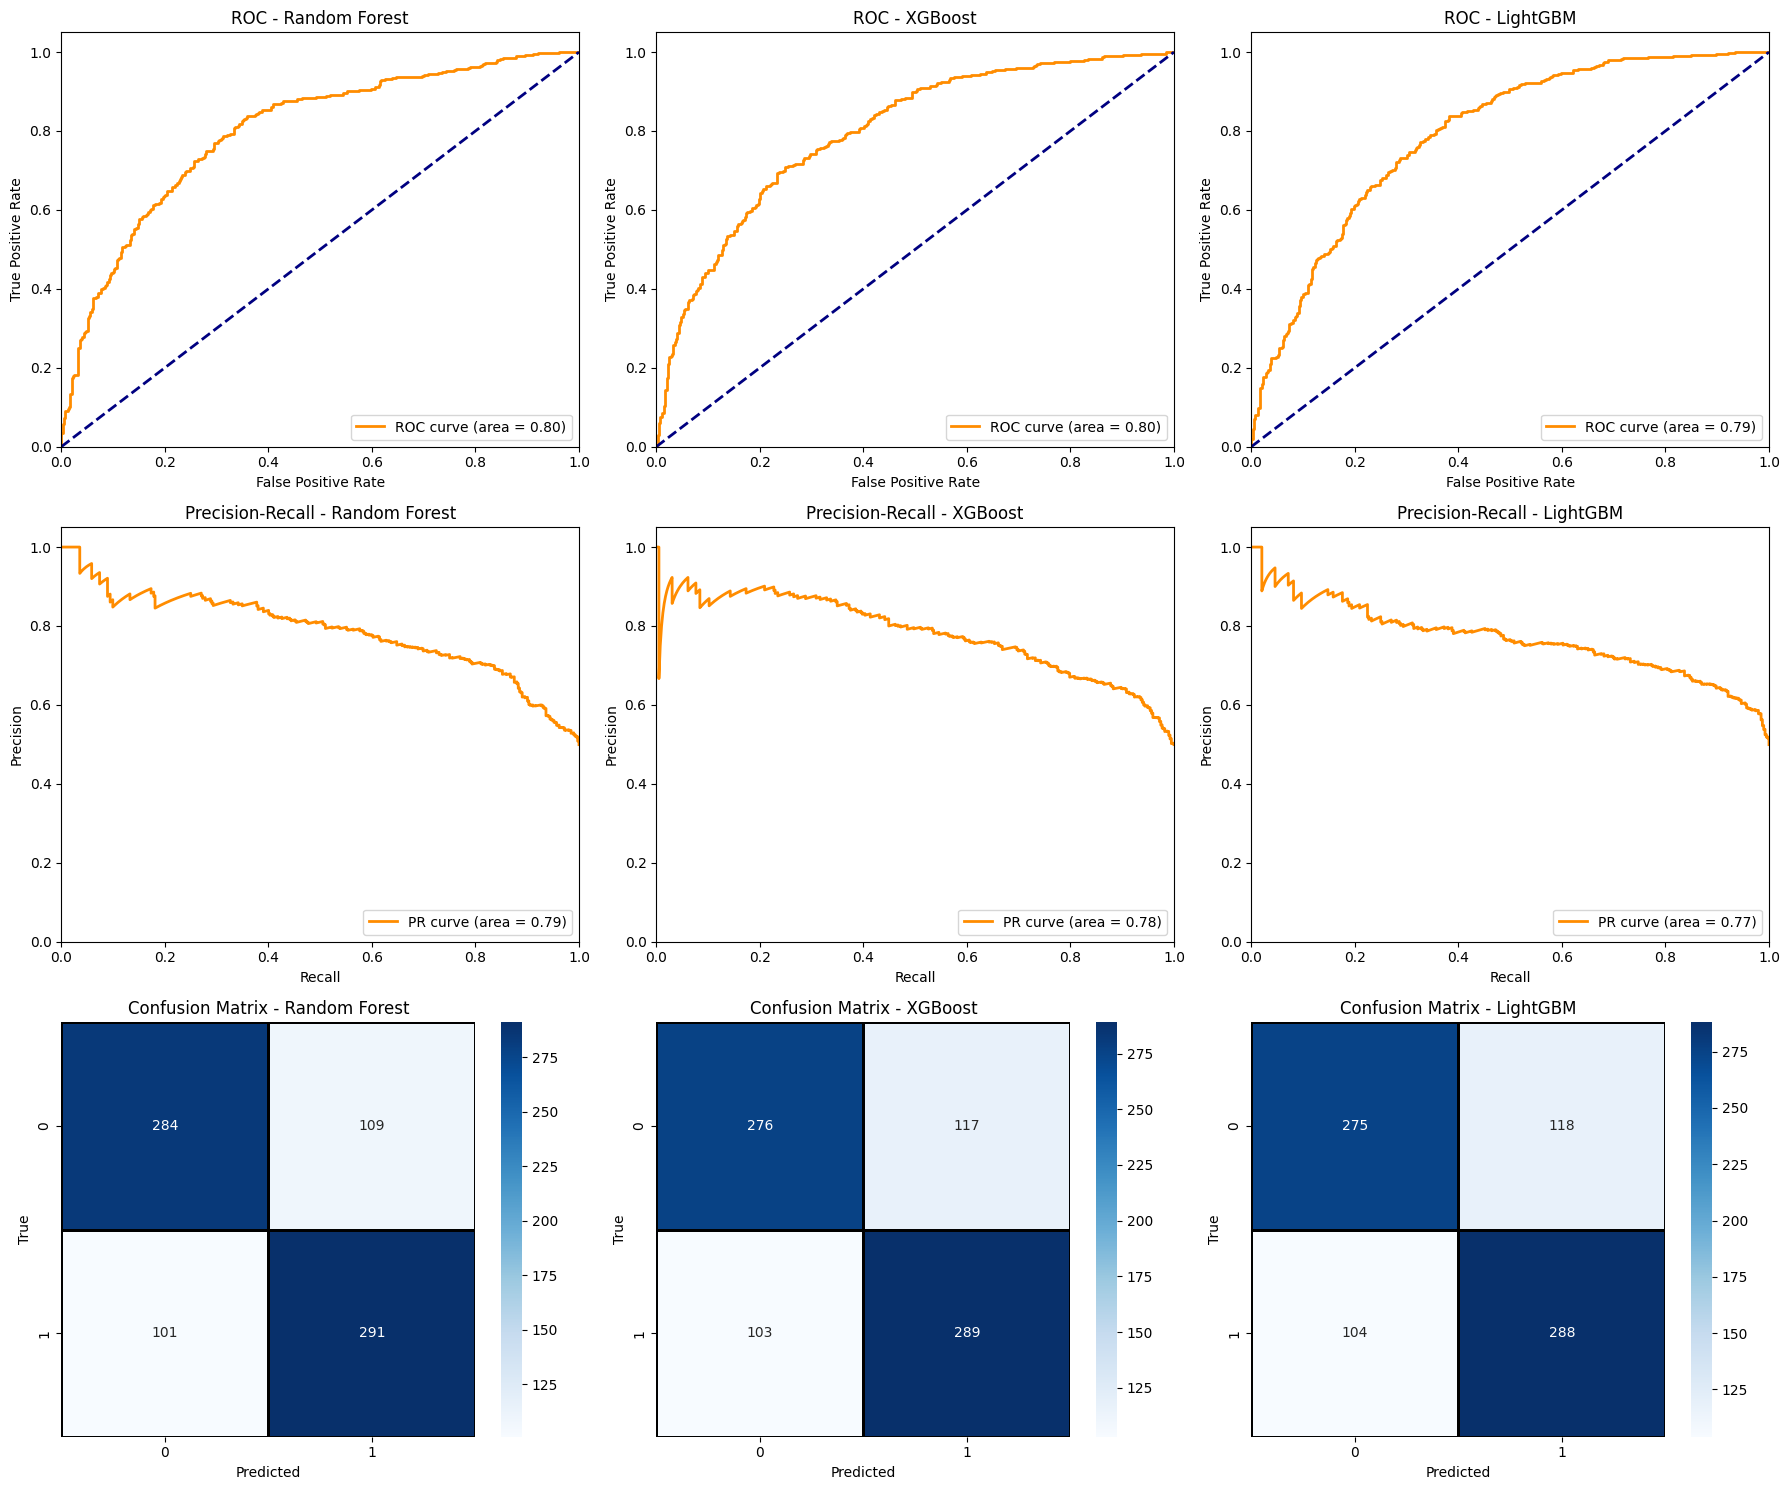

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.732484076433121, 'Precision': 0.7275, 'Recall': 0.7423469387755102, 'F1 Score': 0.734848484848485, 'ROC AUC': 0.7986965778677884}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7197452229299363, 'Precision': 0.7118226600985221, 'Recall': 0.7372448979591837, 'F1 Score': 0.7243107769423559, 'ROC AUC': 0.7974243132367451}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7171974522292993, 'Precision': 0.7093596059113301, 'Recall': 0.7346938775510204, 'F1 Score': 0.7218045112781956, 'ROC AUC': 0.7920561354312718}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7171974522292993,
 'Precision': 0.7093596059113301,
 'Recall': 0.7346938775510204,
 'F1 Score': 0.7218045112781956,
 'ROC AUC': 0.7920561354312718}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7325


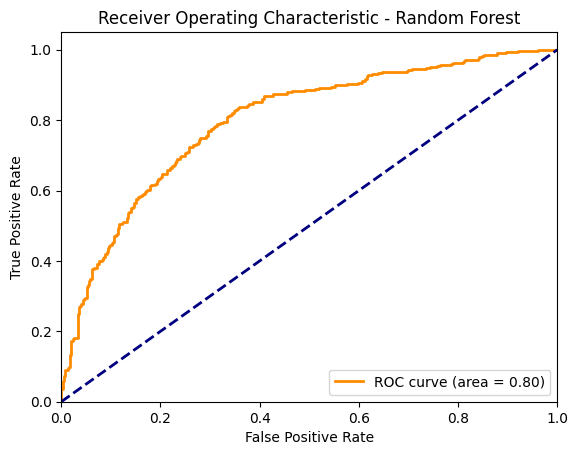

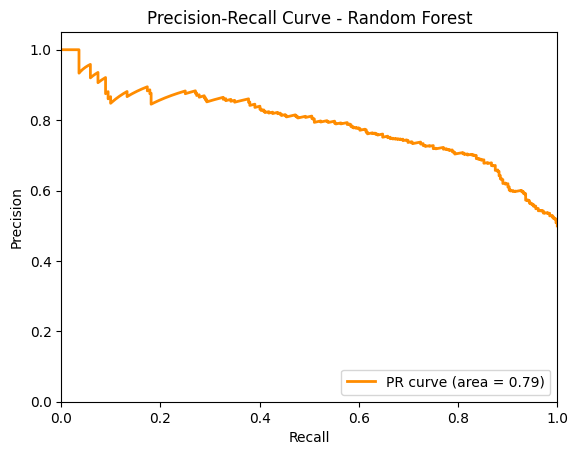

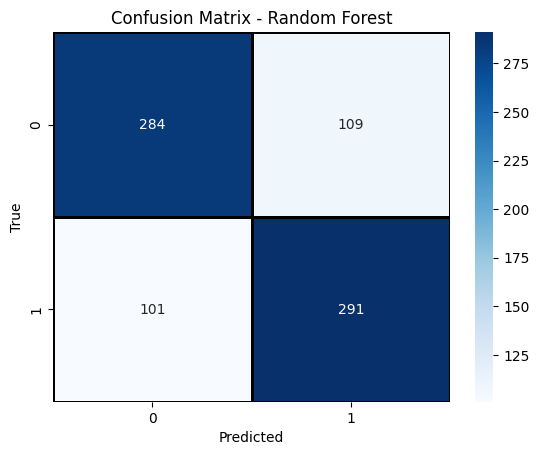

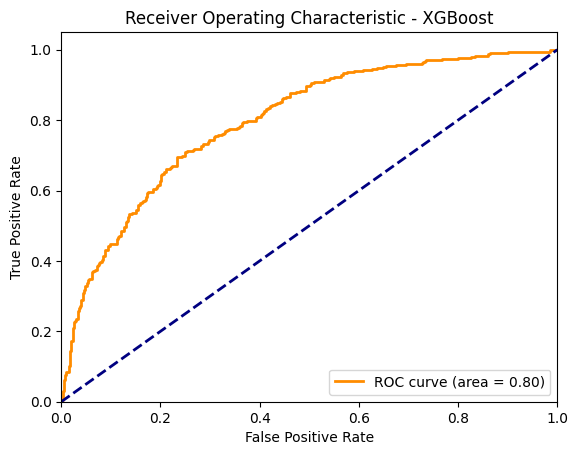

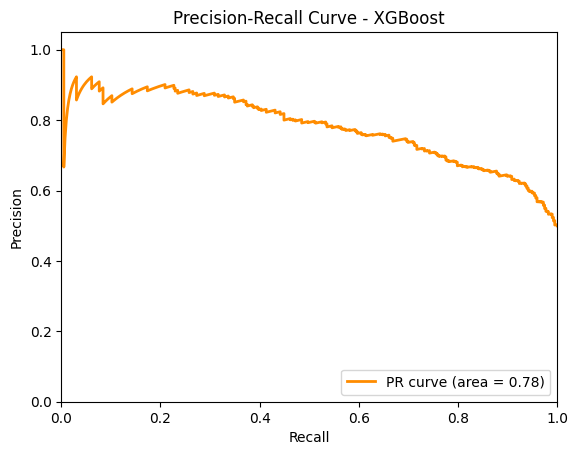

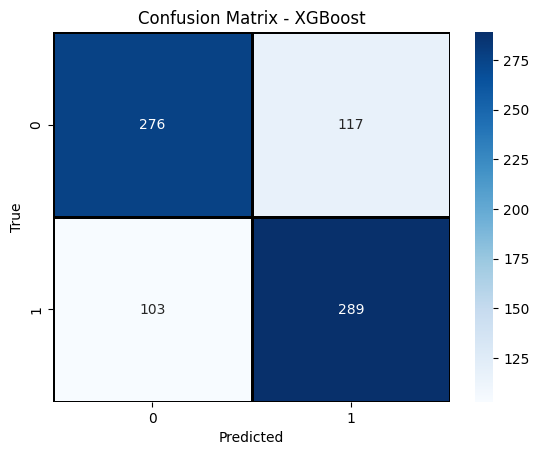

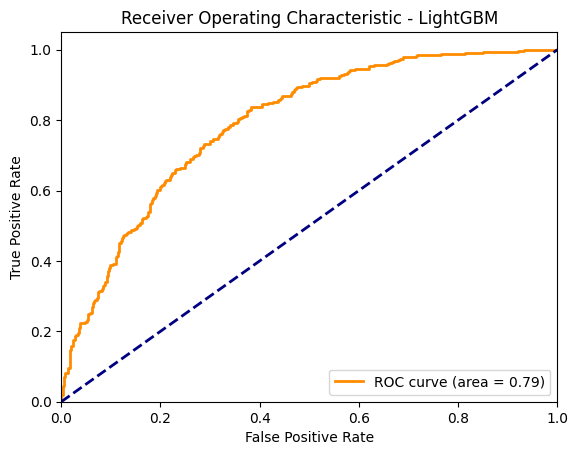

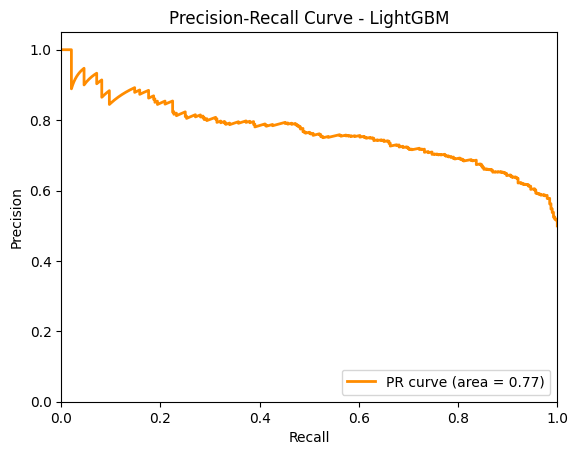

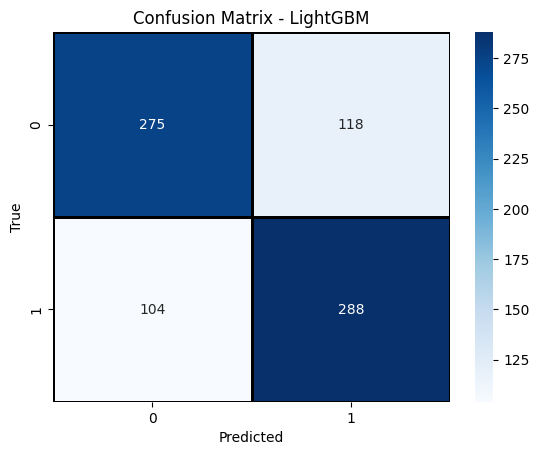

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

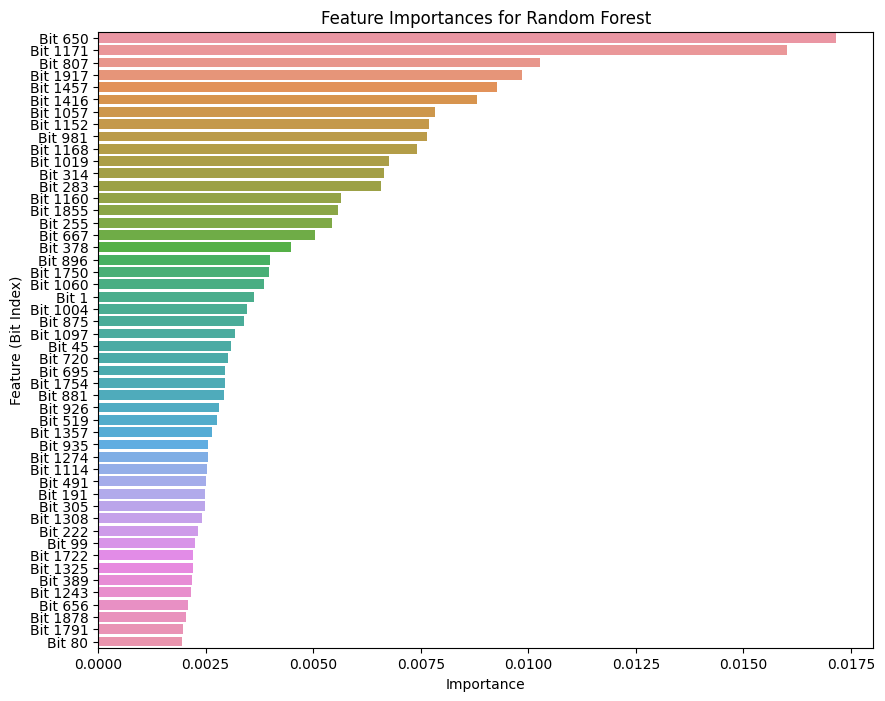

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
